In [38]:
from __future__ import division
import csv
import numpy as np
import pandas as pd
import math
from scipy.optimize import bisect
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pylab as pl
get_ipython().magic(u'matplotlib inline')

In [39]:
grid_data=pd.read_csv('results_GIS_SF_3.csv')
people_range=range(100,10600,500)
#select grid where pop_density>0
grid_data=grid_data[grid_data.pop_density_current != 0]

In [40]:
Electricity_EF_data = pd.read_csv('Electricity_EF_data.csv')
pipe_construction_data = pd.read_csv('pipe_construction_data.csv')
pipe_diameter_data = pd.read_csv('pipe_diameter_data2.csv')
pipe_maintenance_data = pd.read_csv('pipe_maintenance_data.csv')
pump_construction_data = pd.read_csv('pump_construction_data.csv')
slope_index_data = pd.read_csv('slope_index_data.csv')
steel_data = pd.read_csv('steel_data.csv')
transportation_data = pd.read_csv('transportation_data.csv')
treatment_data = pd.read_csv('treatment_data.csv')


#user set parameters
demand=0.2 #m3/person-day
total_demand_central = 241920 #m3/day
total_demand_tertiary = 6048 #m3/day
Electric_Utility="SFPUC"
Electric_Utility_pipes="2010 CA Power Mix"
pipe_material="PE"
miles_to_disposal=30
miles_transport=50
discount=0.04
lifetime_treatment=25
lifetime=50
#pop_density=500 #people/km2
street_density=8000 #m/km2
pump_operating_fraction=0.8
storage_days=3
tank_height=3
retention_time=6 #h
consumption_pressure=20 #m


Treatment_operational_energy_m3=2.4 #MJ/m3
Treatment_capital_energy_m3=0.5 #MJ/m3
Treatment_operational_GHG_m3=0.06  #kgCO2/m3
Treatment_operational_direct_GHG_m3 = 0 #kgCO2/m3
Treatment_capital_GHG_m3= 0.07  #kgCO2/m3
Tertiary_treatment_operational_energy_m3 = 0.9
Tertiary_treatment_operational_GHG_m3 = 0.02


#specify model parameters
electricity_cost=0.12 #$/kwh
specific_weight_water=9.807 #KN/m3
water_density=1000 #kg/m3
gravity=9.8 #m/s2
excavation_cost=4.6 #$/m3
excavation_energy=153 #MJ/m3
excavation_GHG=12 #kgCO2/m3
motor_efficiency=0.95
transport_cost=0.13 #$/ton-mile
transport_energy=8.16 #MJ/ton-mile
transport_GHG=0.656 #kgCo2/ton-mile
steel_cost=0.769 #$/kg
steel_GHG=1.3 #kgCO2/kg
steel_energy=17.5
steel_sheet_mass=186.9
steel_sheet_area=3.72
cement_energy=2820 #MJ/m3
cement_GHG=330 #kgCO2/m3
cement_cost=0.00005 #$/kg
reinf_concrete_energy=190 #Mj/m3
reinf_concrete_GHG=170 #kgCo2/m3
reinf_concrete_cost=115 # $/m3
reinf_concrete_density = 2400 #kg/m3
media_filtration_energy=0.05 #kWh/m3 (Opportunities and Economics of water reuse)
flocculation_energy=0.05 #kWh/m3 of tank volume (Lee,2010)

#specify treatment parameters
MBR_GHG=0.23
sludge_mass=0.1 #kg/m3 water treated
percent_fertilizer= 0.5 #percent of sludge disposed as fertilizer
percent_landfill= (1-percent_fertilizer) 
landfill_GHG=0.04
fertilizer_GHG=0
chlorine_energy=42 #MJ/kg
chlorine_GHG=0.74 #kg/kg
chlorine_mass=15 #mg/L
chlorine_retention_time=1 #h
UV_rating=9.5 #W/m3/d
UV_capital_cost=4 #$/W 2014
UV_usage=12 #h/day
UV_lifetime= 5 #y

RO_membrane_area = 585500  #m2
RO_energy_m2 = 1.3*10**(-4) #MJ/m2
RO_GHG_m2 = 5.6 * 10**(-6) #kg/m2
RO_lifetime = 10

Water_energy_intensity=1.12 #kWh/m3
Water_GHG_intensity=0.36 #kgCO2/m3

#Results
Scale_final=[]
grid_ID_final=[]

elevation_data_final=[]
pump_hp_final=[]
pipe_diameter_final=[]


Total_conveyance_capital_cost_final=[]
Total_conveyance_capital_GHG_final=[]
Total_conveyance_capital_energy_final=[]
Total_conveyance_operational_cost_final=[]
Total_conveyance_operational_GHG_final=[]
Total_conveyance_operational_energy_final=[]

Total_Treatment_Capital_cost_final=[]
Total_Treatment_Capital_energy_final=[]
Total_Treatment_Capital_GHG_final=[]
Total_Treatment_Operational_cost_final=[]
Total_Treatment_Operational_energy_final=[]
Total_Treatment_Operational_GHG_final=[]
Total_Treatment_energy_offsets=[]
Total_Treatment_GHG_offsets=[]

Total_Treatment_operational_energy_final=[]
Total_Treatment_capital_energy_final=[]
Total_Treatment_operational_GHG_final=[]
Total_Treatment_capital_GHG_final=[]

Total_Cost_final=[]
Total_Energy_final=[]
Total_GHG_final=[]


Pipe_capital_cost_final=[]
Pump_capital_cost_final=[]
Tank_capital_cost_final=[]
Pipe_capital_GHG_final=[]
Pump_capital_GHG_final=[]
Tank_capital_GHG_final=[]
Pipe_capital_energy_final=[]
Pipe_construction_energy_final=[]
Pipe_excavation_energy_final=[]
Pipe_transport_energy_final=[]
Pump_capital_energy_final=[]
Tank_capital_energy_final=[]
tank_const_energy_final=[]
tank_transport_energy_final=[]
pump_construction_energy_final=[]
pump_transport_energy_final=[]

Pipe_construction_GHG_final=[]
Pipe_excavation_GHG_final=[]
Pipe_transport_GHG_final=[]
Pump_capital_GHG_final=[]
Tank_capital_GHG_final=[]
tank_const_GHG_final=[]
tank_transport_GHG_final=[]
pump_construction_GHG_final=[]
pump_transport_GHG_final=[]

Pipe_operat_cost_final=[]
Pump_operat_cost_final=[]
Pipe_operat_GHG_final=[]
Pump_operat_GHG_final=[]
Pipe_operat_energy_final=[]
Pump_operat_energy_final=[]

MBR_Capital_energy_final=[]
MBR_Capital_GHG_final=[]
CoagFlocc_Capital_energy_final=[]
CoagFlocc_Capital_GHG_final=[]

MBR_Operational_energy_final=[]
MBR_Operational_GHG_final=[]
Chlorine_operational_energy_final=[]
Chlorine_operational_GHG_final=[]


Sludge_transport_energy_final=[]
Sludge_transport_GHG_final=[]
Sludge_disposal_GHG_final=[]

Treatment_capital_energy_final=[]
Treatment_capital_GHG_final=[]
Treatment_operational_energy_final=[]
Treatment_operational_GHG_final=[]
Treatment_operational_direct_GHG_final=[]
Tertiary_Treatment_operational_energy_final=[]
Tertiary_Treatment_operational_GHG_final=[]

UV_Capital_cost_final=[]
UV_Capital_energy_final=[]
UV_Capital_GHG_final=[]
UV_Operational_energy_final=[]
UV_Operational_cost_final=[]
UV_Operational_GHG_final=[]
Chlorine_operational_energy_final=[]
Chlorine_operational_GHG_final=[]

RO_Capital_energy_final=[]
RO_Capital_GHG_final=[]

Headloss_total=[]
Head_total=[]
Pressure_total=[]
dynamic_total=[]
Total_conveyance_operational_energy_collection=[]
Total_conveyance_operational_GHG_collection=[]
                


elevation_data=[]

In [41]:
slope_index_grid=grid_data['slope_index']
grid_index=grid_data['grid_ID']
length_centr=grid_data['length_m']
z_max=grid_data['Head_central_elevation']
pop_dens=grid_data['pop_density_current']
collection_energy=grid_data['collection_MJ_m3']
slp_index=slope_index_grid.tolist()
grd_index=grid_index.tolist()
z_max_rt=z_max.tolist()
length_cnt=length_centr.tolist()
pop_dens_index=pop_dens.tolist()
collection_energy_index=collection_energy.tolist()
grid_slope_length=zip(grd_index,slp_index,length_cnt,z_max_rt,pop_dens_index,collection_energy_index)


In [42]:
# ##Conveyance

#Iterate for each grid
for value in grid_slope_length:
    grid_ID=value[0]
    slope_index_grid=value[1]
    length_centralized_m=value[2]
    z_max_route=value[3]
    pop_density=value[4]
    collection_energy=value[5]
    
    #Calculate pipe length and elevation
    for i in people_range:
        people=i
        pipe_length_dec=2*people/pop_density*street_density
        if pipe_length_dec>street_density/2:
            pipe_length_dec=street_density/2
        if people>pop_density/2:
            elevation_dec=500*slope_index_grid
        else: 
            elevation_dec=math.sqrt(people/pop_density)*slope_index_grid*1000
        if elevation_dec==0:
            elevation_dec=0.1
        pipe_length=pipe_length_dec+length_centralized_m
        elevation=elevation_dec+z_max_route

        
        #Calculate pipe diameter
        total_dem=people*demand/(24) #m3/h
        if total_dem<1:
            total_dem=1
        else:
            total_dem=round(total_dem)

        pd_data = pipe_diameter_data
        k=pd_data.set_index('Flow_Rate_m3_h')
        pipe_diameter=k.PVC_Diameter_mm[total_dem]
        

        total_demand=people*demand/(24) #m3/h
        demand_day=total_demand*24
        pipe_area=math.pi*(pipe_diameter*0.001/2)**2
        pipe_velocity=total_dem/(3600*pipe_area)

        #normDiameterList = (40, 50, 63, 75, 90, 100, 125, 160, 200, 250, 300, 350, 400, 450, 500, 600) 
        normDiameterList = (50, 100, 160, 200, 350, 375, 450)
        index=normDiameterList.index(pipe_diameter)
        index=index+1
        pipe_diameter=normDiameterList[index]

        h1=0.03*pipe_length/((pipe_diameter)*0.001)*(pipe_velocity**2)/(2*9.81)
        threshold=0.30*(elevation)

        while h1>threshold:
            index=index+1
            pipe_diameter=normDiameterList[index]
            pipe_area_2=math.pi*(pipe_diameter*0.001/2)**2
            pipe_velocity=total_demand/(3600*pipe_area_2)
            h1=0.03*pipe_length/((pipe_diameter)*0.001)*(pipe_velocity**2)/(2*9.81)

        if pipe_velocity<=2.5:
            pipe_diameter=pipe_diameter
        else:
            index=index+1
            pipe_diameter=normDiameterList[index]
        
        
        

        pipe_area_2=math.pi*(pipe_diameter*0.001/2)**2
        pipe_velocity_2=total_demand/(3600*pipe_area_2)


        #Pipes
        #Piping construction
        pipe_construction_df=pipe_construction_data[(pipe_construction_data['Material'] == (pipe_material))]
        h=pipe_construction_df.set_index('size_mm')
        pipe_emissions_EF=h.Emissions_kgCO2_eq_m[pipe_diameter]
        pipe_energy_EF=h.Embodied_Energy_MJ_kg[pipe_diameter]
        pipe_cost_EF=h.cost_2012_m[pipe_diameter]
        pipe_weight=h.Wt_kg_m[pipe_diameter]
        pipe_excav_vol=h.Excavation_vol_m3_m[pipe_diameter]

        #Electricity GHG
        Electricity_GHG_df=Electricity_EF_data[(Electricity_EF_data['Name'] == (Electric_Utility))]
        Electricity_GHG_LCA=Electricity_GHG_df['EF_Lifecycle_kg_kWh'].iloc[0]
        Electricity_GHG_direct=Electricity_GHG_df['EF_Direct_kg_kWh'].iloc[0]
        
        Electricity_GHG_df_pipes=Electricity_EF_data[(Electricity_EF_data['Name'] == (Electric_Utility_pipes))]
        Electricity_GHG_LCA_pipes=Electricity_GHG_df['EF_Lifecycle_kg_kWh'].iloc[0]
        
        Pipe_const_cost=length_centralized_m*(pipe_cost_EF)/lifetime/(demand_day*365)
        Pipe_const_energy=(length_centralized_m*(pipe_energy_EF)*(pipe_weight))/lifetime/(demand_day*365)
        #Pipe_const_GHG=Pipe_const_energy/3.6*Electricity_GHG_LCA_pipes
        Pipe_const_GHG=pipe_emissions_EF*length_centralized_m/lifetime/(demand_day*365)

        
        #Piping excavation
        Pipe_mass=length_centralized_m*(pipe_weight)
        Pipe_excavation_vol=length_centralized_m*(pipe_excav_vol)
        Pipe_excavation_cost=Pipe_excavation_vol*(excavation_cost)/lifetime/(demand_day*365)
        Pipe_excavation_energy=Pipe_excavation_vol*(excavation_energy)/lifetime/(demand_day*365)
        Pipe_excavation_GHG=Pipe_excavation_vol*(excavation_GHG)/lifetime/(demand_day*365)

        #Piping transportation
        Pipe_transport_cost=transport_cost*miles_transport*Pipe_mass/(1000*lifetime)/(demand_day*365)
        Pipe_transport_energy=transport_energy*miles_transport*Pipe_mass/(1000*lifetime)/(demand_day*365)
        Pipe_transport_GHG=transport_GHG*miles_transport*Pipe_mass/(1000*lifetime)/(demand_day*365)


        #Piping maintenance
        pipe_maintenance_data['cost_discount_y'] = pipe_maintenance_data['cost_m']*length_centralized_m/((1+discount)**(pipe_maintenance_data['year_']-1))
        pipe_maintenance_data['energy_y'] = pipe_maintenance_data['KWh_m']*pipe_length*3.6
        pipe_maintenance_data['GHG_y'] = pipe_maintenance_data['energy_y']/3.6*Electricity_GHG_LCA_pipes

        pipe_maint_lifetime=pipe_maintenance_data[pipe_maintenance_data['year_'] <= lifetime]
        pipe_maint_cost=pipe_maint_lifetime['cost_discount_y'].sum()/lifetime/(demand_day*365)
        pipe_maint_GHG=pipe_maint_lifetime['GHG_y'].sum()/lifetime/(demand_day*365)
        pipe_maint_energy=pipe_maint_lifetime['energy_y'].sum()/lifetime/(demand_day*365)



        #Totals Pipes
        Pipe_capital_cost=(Pipe_const_cost+Pipe_excavation_cost+Pipe_transport_cost)
        Pipe_capital_energy=(Pipe_const_energy+Pipe_excavation_energy+Pipe_transport_energy)
        Pipe_capital_GHG=(Pipe_const_GHG+Pipe_excavation_GHG+Pipe_transport_GHG)

        Pipe_operat_cost=pipe_maint_cost
        Pipe_operat_energy=pipe_maint_energy
        Pipe_operat_GHG=pipe_maint_GHG


        #Calculate headloss
        headloss=0.03*pipe_length/((pipe_diameter)*0.001)*(pipe_velocity_2**2)/(2*9.81)


        #Calculate Pressure
        head=elevation-0
        pressure=((pipe_velocity_2**2)*water_density/2+(consumption_pressure/10*101325)+(head*gravity*water_density)+(headloss*gravity*water_density))
        total_head=pressure/(water_density*gravity)

        headloss_m=headloss
        head_m=head
        pressure_m=consumption_pressure
        dynamic_pressure=((pipe_velocity_2**2)/(2*gravity))
        
        
        
        #Calculate pump effieciency
        p_hp=(specific_weight_water*total_head*(total_demand/3600)/(0.4*motor_efficiency))*1.34
        if p_hp<3:
            pump_efficiency=0.4
        elif 3<=p_hp<7:
            pump_efficiency=0.45
        elif 7<=p_hp<15:
            pump_efficiency=0.5
        elif 15<=p_hp<40:
            pump_efficiency=0.55
        elif 40<=p_hp<60:
            pump_efficiency=0.6
        else:
            pump_efficiency=0.7
        p_hp=(specific_weight_water*total_head*(total_demand/3600)/(pump_efficiency*motor_efficiency))*1.34
        
        headloss_energy=specific_weight_water*headloss_m*(1/(24*365*3600))*pump_operating_fraction*24*365/(pump_efficiency*motor_efficiency)
        head_energy=specific_weight_water*head_m*(1/(24*365*3600))*pump_operating_fraction*24*365/(pump_efficiency*motor_efficiency)
        pressure_energy=specific_weight_water*pressure_m*(1/(24*365*3600))*pump_operating_fraction*24*365/(pump_efficiency*motor_efficiency)
        dynamic_energy=specific_weight_water*dynamic_pressure*(1/(24*365*3600))*pump_operating_fraction*24*365/(pump_efficiency*motor_efficiency)
      
    #Calculating actual pump horsepower
        Pump_energy_hp=p_hp*3.6*8765/1.34*pump_operating_fraction
        hp=round(((Pump_energy_hp/3.6)*1.34/8765),2)
        if hp<=0.5:
            pump_hp=round(((Pump_energy_hp/3.6)*1.34/8765)*2,1)/2
        elif 0.5<hp<10:
            pump_hp=round(((Pump_energy_hp/3.6)*1.34/8765),0)
        elif 10<=hp<100:
            pump_hp=round(((Pump_energy_hp/3.6)*1.34/8765)/10,0)*10
        else:
            pump_hp=round(((Pump_energy_hp/3.6)*1.34/8765)*2/1000,1)*1000/2
            
        if pump_hp<0.05:
            pump_hp=0.05

 

        #Pump Operation
        Pump_operat_energy=specific_weight_water*total_head*(total_demand/3600)*pump_operating_fraction*24*365/(pump_efficiency*motor_efficiency)*3.6/(demand_day*365)
        Pump_operat_GHG=Pump_operat_energy/3.6*Electricity_GHG_LCA
        Pump_operat_cost=Pump_operat_energy/3.6*electricity_cost



        #Pump Construction
        t=pump_construction_data.set_index('Rating_hp')
        pump_cost_EF=t.Cost_2012[pump_hp]
        pump_energy_EF=t.Embodied_Energy_MJ[pump_hp]
        pump_GHG_EF=t.Emissions_kgCO_eq[pump_hp]
        pump_weight=t.Wt_kg[pump_hp]

        pump_construction_energy=pump_energy_EF/lifetime_treatment/(demand_day*365)
        pump_construction_GHG=pump_GHG_EF/lifetime_treatment/(demand_day*365)
        pump_construction_cost=pump_cost_EF/lifetime_treatment/(demand_day*365)

        pump_transport_cost=pump_weight*miles_transport*transport_cost/(1000*lifetime_treatment)/(demand_day*365)
        pump_transport_energy=pump_weight*miles_transport*transport_energy/(1000*lifetime_treatment)/(demand_day*365)
        pump_transport_GHG=pump_weight*miles_transport*transport_GHG/(1000*lifetime_treatment)/(demand_day*365)


        #Totals Pumps
        Pump_capital_cost=pump_construction_cost+pump_transport_cost
        Pump_capital_energy=pump_construction_energy+pump_transport_energy
        Pump_capital_GHG=pump_construction_GHG+pump_transport_GHG


        
        #Tanks
        tank_volume=storage_days*total_demand_tertiary #m3
        tank_radius=math.sqrt(tank_volume/(math.pi*tank_height))
        tank_area=2*math.pi*tank_radius*tank_height+2*math.pi*tank_radius**2
        tank_cement_volume=0.1*tank_area
        tank_mass_steel=round(tank_area/steel_sheet_area,0)*steel_sheet_mass
        
        
        #tank construction
        tank_const_cost=tank_cement_volume*reinf_concrete_cost/lifetime/(total_demand_tertiary*365)
        tank_const_energy=tank_cement_volume*reinf_concrete_energy/lifetime/(total_demand_tertiary*365)
        tank_const_GHG=tank_cement_volume*reinf_concrete_GHG/lifetime/(total_demand_tertiary*365)

        #tank transport
        tank_transport_cost=(tank_cement_volume*reinf_concrete_density)*transport_cost*miles_transport/(lifetime*1000)/(total_demand_tertiary*365)
        tank_transport_energy=(tank_cement_volume*reinf_concrete_density)*transport_energy*miles_transport/(lifetime*1000)/(total_demand_tertiary*365)
        tank_transport_GHG=(tank_cement_volume*reinf_concrete_density)*transport_GHG*miles_transport/(lifetime*1000)/(total_demand_tertiary*365)



        #Tanks Totals
        Tank_capital_cost=tank_const_cost+tank_transport_cost
        Tank_capital_energy=tank_const_energy+tank_transport_energy
        Tank_capital_GHG=tank_const_GHG+tank_transport_GHG

        
        

        #Conveyance Totals
        
        Collection_pumping_energy=collection_energy #MJ/y
        Collection_pumping_GHG=Collection_pumping_energy/3.6*Electricity_GHG_LCA
        Total_conveyance_capital_cost_y=Pipe_capital_cost+Pump_capital_cost+Tank_capital_cost
        Total_conveyance_capital_GHG_y=Pipe_capital_GHG+Pump_capital_GHG+Tank_capital_GHG
        Total_conveyance_capital_energy_y=Pipe_capital_energy+Pump_capital_energy+Tank_capital_energy

        Total_conveyance_operational_cost_y=Pipe_operat_cost+Pump_operat_cost
        Total_conveyance_operational_GHG_y=Pipe_operat_GHG+Pump_operat_GHG
        Total_conveyance_operational_energy_y=Pipe_operat_energy+Pump_operat_energy
        
                
        ###Treatment
        
        #Total Centralized Treatment
        Central_treatment_operational_energy_y=Treatment_operational_energy_m3
        Central_treatment_capital_energy_y=Treatment_capital_energy_m3
        Treatment_operational_direct_GHG_y = Treatment_operational_direct_GHG_m3
        Tertiary_treatment_operational_energy_y = Tertiary_treatment_operational_energy_m3
        Tertiary_treatment_operational_GHG_y = Tertiary_treatment_operational_GHG_m3

        Central_treatment_operational_GHG_y=Treatment_operational_GHG_m3
        Central_treatment_capital_GHG_y=Treatment_capital_GHG_m3
        
        #Treatment for Recycling
        
        
        # RO
        RO_Capital_energy_y=RO_membrane_area*RO_energy_m2/RO_lifetime/(total_demand_tertiary*365)
        RO_Capital_GHG_y=RO_membrane_area*RO_GHG_m2/RO_lifetime/(total_demand_tertiary*365)
        
        
        #UV
        UV_Capital_cost_y=UV_capital_cost*UV_rating*total_demand_tertiary/UV_lifetime/(total_demand_tertiary*365)
        UV_Capital_energy_y=UV_rating*total_demand_tertiary*UV_capital_cost*0.76*7.8/UV_lifetime/(total_demand_tertiary*365)
        UV_Capital_GHG_y=UV_rating*total_demand_tertiary*UV_capital_cost*558*0.76/(UV_lifetime*1000)/(total_demand_tertiary*365)
        UV_Operational_energy_y=UV_rating*total_demand_tertiary*UV_usage*365*3.6/1000/(total_demand_tertiary*365)
        UV_Operational_cost_y=UV_Operational_energy_y/3.6*electricity_cost
        UV_Operational_GHG_y=UV_Operational_energy_y/3.6*Electricity_GHG_LCA
        
                    
        #Chlorination
        chlorine_volume=chlorine_retention_time/24*total_demand_tertiary
        chlorine_radius=math.sqrt(chlorine_volume/(math.pi*1))
        chlorine_cement_volume=((2*math.pi*chlorine_radius*1)+math.pi*chlorine_radius**2)*0.10
        
        Chlorine_manufacturing_energy_y=chlorine_mass*chlorine_energy/1000+chlorine_cement_volume*reinf_concrete_energy/lifetime_treatment/(total_demand_tertiary*365)
        Chlorine_manufacturing_GHG_y=chlorine_mass*chlorine_GHG/1000+chlorine_cement_volume*reinf_concrete_GHG/lifetime_treatment/(total_demand_tertiary*365)
        Chlorine_transport_energy_y=chlorine_mass*transport_energy*total_demand_central*365*miles_transport/1000000/(total_demand_tertiary*365)
        Chlorine_transport_GHG_y=chlorine_mass*transport_GHG*total_demand_central*365*miles_transport/1000000/(total_demand_tertiary*365)
        Chlorine_operational_energy_y=Chlorine_manufacturing_energy_y+Chlorine_transport_energy_y
        Chlorine_operational_GHG_y=Chlorine_manufacturing_GHG_y+Chlorine_transport_GHG_y
        
    
        #Tanks Totals
        Tank_capital_cost=tank_const_cost+tank_transport_cost
        Tank_capital_energy=tank_const_energy+tank_transport_energy
        Tank_capital_GHG=tank_const_GHG+tank_transport_GHG
        
        #Sludge
        Sludge_transport_energy_y=sludge_mass*0.2*total_demand_central*365*miles_to_disposal*transport_energy/1000/(total_demand_central*365)
        Sludge_transport_GHG_y=sludge_mass*0.2*demand_day*365*miles_to_disposal*transport_GHG/1000/(demand_day*365)
        Sludge_disposal_GHG_y=landfill_GHG*sludge_mass*0.2*percent_landfill/(1000)+fertilizer_GHG*sludge_mass*0.2*percent_fertilizer/(1000)
                
        Total_Treatment_Capital_energy=Central_treatment_capital_energy_y+UV_Capital_energy_y+RO_Capital_energy_y
        Total_Treatment_Operational_energy=Central_treatment_operational_energy_y+Tertiary_treatment_operational_energy_y+UV_Operational_energy_y+Chlorine_operational_energy_y+Sludge_transport_energy_y
        Total_Treatment_Capital_GHG=Central_treatment_capital_GHG_y+UV_Capital_GHG_y+RO_Capital_GHG_y
        Total_Treatment_Operational_GHG=Central_treatment_operational_GHG_y+Tertiary_treatment_operational_GHG_y+UV_Operational_GHG_y+Chlorine_operational_GHG_y+Sludge_transport_GHG_y+Sludge_disposal_GHG_y
        
        #Treatment_energy_offsets_y=-(people*demand*365*Water_energy_intensity)
        #Treatment_GHG_offsets_y=-(people*demand*365*Water_GHG_intensity)
        Total_Energy_m3=Total_Treatment_Capital_energy+Total_Treatment_Operational_energy+Total_conveyance_operational_energy_y+Total_conveyance_capital_energy_y+Collection_pumping_energy
        Total_GHG_m3= Total_Treatment_Capital_GHG+Total_Treatment_Operational_GHG+Total_conveyance_operational_GHG_y+Total_conveyance_capital_GHG_y+Collection_pumping_GHG+Treatment_operational_direct_GHG_y

      
        #Results
        Scale_final.append(people)
        grid_ID_final.append(grid_ID)
        Total_conveyance_capital_cost_final.append(Total_conveyance_capital_cost_y)
        Total_conveyance_capital_GHG_final.append(Total_conveyance_capital_GHG_y)
        Total_conveyance_capital_energy_final.append(Total_conveyance_capital_energy_y)
        Total_conveyance_operational_cost_final.append(Total_conveyance_operational_cost_y)
        Total_conveyance_operational_GHG_final.append(Total_conveyance_operational_GHG_y)
        Total_conveyance_operational_energy_final.append(Total_conveyance_operational_energy_y)
        Total_conveyance_operational_energy_collection.append(Collection_pumping_energy)
        Total_conveyance_operational_GHG_collection.append(Collection_pumping_GHG)
        
        
        Headloss_total.append(headloss_energy)
        Head_total.append(head_energy)
        Pressure_total.append(pressure_energy)
        dynamic_total.append(dynamic_energy)
                
        
        Total_Treatment_operational_energy_final.append(Total_Treatment_Operational_energy)
        Total_Treatment_capital_energy_final.append(Total_Treatment_Capital_energy)
        Total_Treatment_operational_GHG_final.append(Total_Treatment_Operational_GHG)
        Total_Treatment_capital_GHG_final.append(Total_Treatment_Capital_GHG)
        Treatment_operational_direct_GHG_final.append(Treatment_operational_direct_GHG_y)

        Pipe_capital_cost_final.append(Pipe_capital_cost)
        Pump_capital_cost_final.append(Pump_capital_cost)
        Tank_capital_cost_final.append(Tank_capital_cost)
        Pipe_capital_GHG_final.append(Pipe_capital_GHG)
        Pump_capital_GHG_final.append(Pump_capital_GHG)
        Tank_capital_GHG_final.append(Tank_capital_GHG)
        Pipe_capital_energy_final.append(Pipe_capital_energy)
        Pump_capital_energy_final.append(Pump_capital_energy)
        Tank_capital_energy_final.append(Tank_capital_energy)

        Pipe_operat_cost_final.append(Pipe_operat_cost)
        Pump_operat_cost_final.append(Pump_operat_cost)
        Pipe_operat_GHG_final.append(Pipe_operat_GHG)
        Pump_operat_GHG_final.append(Pump_operat_GHG)
        Pipe_operat_energy_final.append(Pipe_operat_energy)
        Pump_operat_energy_final.append(Pump_operat_energy)
        
        Pipe_construction_energy_final.append(Pipe_const_energy)
        Pipe_excavation_energy_final.append(Pipe_excavation_energy)
        Pipe_transport_energy_final.append(Pipe_transport_energy)
        tank_const_energy_final.append(tank_const_energy)
        tank_transport_energy_final.append(tank_transport_energy)
        pump_construction_energy_final.append(pump_construction_energy)
        pump_transport_energy_final.append(pump_transport_energy)
        
        Pipe_construction_GHG_final.append(Pipe_const_GHG)
        Pipe_excavation_GHG_final.append(Pipe_excavation_GHG)
        Pipe_transport_GHG_final.append(Pipe_transport_GHG)
        tank_const_GHG_final.append(tank_const_GHG)
        tank_transport_GHG_final.append(tank_transport_GHG)
        pump_construction_GHG_final.append(pump_construction_GHG)
        pump_transport_GHG_final.append(pump_transport_GHG)
        
        Treatment_capital_energy_final.append(Central_treatment_capital_energy_y)
        Treatment_capital_GHG_final.append(Central_treatment_capital_GHG_y)
        Treatment_operational_energy_final.append(Central_treatment_operational_energy_y)
        Treatment_operational_GHG_final.append(Central_treatment_operational_GHG_y)
        Tertiary_Treatment_operational_energy_final.append(Tertiary_treatment_operational_energy_y)
        Tertiary_Treatment_operational_GHG_final.append(Tertiary_treatment_operational_GHG_y)

        RO_Capital_energy_final.append(RO_Capital_energy_y)
        RO_Capital_GHG_final.append(RO_Capital_GHG_y)
        UV_Capital_cost_final.append(UV_Capital_cost_y)
        UV_Capital_energy_final.append(UV_Capital_energy_y)
        UV_Capital_GHG_final.append(UV_Capital_GHG_y)
        UV_Operational_energy_final.append(UV_Operational_energy_y)
        UV_Operational_cost_final.append(UV_Operational_cost_y)
        UV_Operational_GHG_final.append(UV_Operational_GHG_y)
        Chlorine_operational_energy_final.append(Chlorine_operational_energy_y)
        Chlorine_operational_GHG_final.append(Chlorine_operational_GHG_y)
        Sludge_transport_energy_final.append(Sludge_transport_energy_y)
        Sludge_transport_GHG_final.append(Sludge_transport_GHG_y)
        Sludge_disposal_GHG_final.append(Sludge_disposal_GHG_y)
        

        elevation_data_final.append(elevation)
        pump_hp_final.append(pump_hp)
        pipe_diameter_final.append(pipe_diameter)
       
        
        
        Total_Energy_final.append(Total_Energy_m3)
        Total_GHG_final.append(Total_GHG_m3)



In [43]:
#total_energy DataFrame
label_pairs = list(zip(grid_ID_final,Scale_final,Total_conveyance_capital_energy_final,Total_conveyance_operational_energy_final,Total_Treatment_operational_energy_final,Total_Treatment_capital_energy_final,Total_conveyance_operational_energy_collection, Total_Energy_final))
total_energy=pd.DataFrame(label_pairs)
total_energy.columns = ['grid_ID','People', 'Total_conveyance_capital_energy_central_y','Total_conveyance_operational_energy_central_y','Total_Treatment_operational_energy_y','Total_Treatment_capital_energy_y','Total_conveyance_operational_energy_collection_y','Total_Energy_m3']
# total_energy['Scale']=(total_energy['People'])*0.2*365
# total_energy['Total_conveyance_capital_energy_central_m3']=(total_energy['Total_conveyance_capital_energy_central_y'])/(total_energy['Scale'])
# total_energy['Total_conveyance_operational_energy_central_m3']=(total_energy['Total_conveyance_operational_energy_central_y'])/(total_energy['Scale'])
# total_energy['Total_Treatment_operational_energy_m3']=(total_energy['Total_Treatment_operational_energy_y'])/(total_energy['Scale'])
# total_energy['Total_Treatment_capital_energy_m3']=(total_energy['Total_Treatment_capital_energy_y'])/(total_energy['Scale'])
# total_energy['Total_Energy_final_central_m3']=(total_energy['Total_Energy_final_central_y'])/(total_energy['Scale'])
# total_energy['Total_conveyance_operational_energy_collection_m3']=(total_energy['Total_conveyance_operational_energy_collection_y'])/(total_energy['Scale'])

In [44]:
#total_GHG DataFrame
label_pairs = list(zip(grid_ID_final,Scale_final,Total_conveyance_capital_GHG_final,Total_conveyance_operational_GHG_final,Total_Treatment_capital_GHG_final,Total_Treatment_operational_GHG_final,Treatment_operational_direct_GHG_final,Total_conveyance_operational_GHG_collection,Total_GHG_final))
total_GHG=pd.DataFrame(label_pairs)
total_GHG.columns = ['grid_ID','People', 'Total_conveyance_capital_GHG_central_y','Total_conveyance_operational_GHG_central_y','Total_Treatment_capital_GHG_y','Total_Treatment_operational_GHG_y', 'Treatment_operational_direct_GHG_y' ,'Total_conveyance_operational_GHG_collection_y','Total_GHG_m3']
# total_GHG['Scale']=(total_GHG['People'])*0.2*365
# total_GHG['Total_conveyance_capital_GHG_central_m3']=(total_GHG['Total_conveyance_capital_GHG_central_y'])/(total_GHG['Scale'])
# total_GHG['Total_conveyance_operational_GHG_central_m3']=(total_GHG['Total_conveyance_operational_GHG_central_y'])/(total_GHG['Scale'])
# total_GHG['Total_Treatment_operational_GHG_m3']=(total_GHG['Total_Treatment_operational_GHG_y'])/(total_GHG['Scale'])
# total_GHG['Total_Treatment_capital_GHG_m3']=(total_GHG['Total_Treatment_capital_GHG_y'])/(total_GHG['Scale'])
# total_GHG['Total_GHG_final_central_m3']=(total_GHG['Total_GHG_final_central_y'])/(total_GHG['Scale'])
# total_GHG['Total_conveyance_operational_GHG_collection_m3']=(total_GHG['Total_conveyance_operational_GHG_collection_y'])/(total_GHG['Scale'])

In [45]:
#energy by process DataFrame
label_pairs = list(zip(grid_ID_final,Scale_final,Pipe_capital_energy_final,Pump_capital_energy_final,Tank_capital_energy_final, Pipe_operat_energy_final, Pump_operat_energy_final,Pipe_construction_energy_final,Pipe_excavation_energy_final,Pipe_transport_energy_final,tank_const_energy_final,tank_transport_energy_final,pump_construction_energy_final,pump_transport_energy_final,Treatment_operational_energy_final,Treatment_capital_energy_final,Tertiary_Treatment_operational_energy_final,RO_Capital_energy_final,UV_Capital_energy_final,UV_Operational_energy_final,Chlorine_operational_energy_final,Sludge_transport_energy_final,Total_conveyance_operational_energy_collection))
process_energy = pd.DataFrame(label_pairs)
process_energy.columns = ['grid_ID','People', 'Pipe_capital_energy_final_y','Pump_capital_energy_final_y','Tank_capital_energy_final_y', 'Pipe_operat_energy_final_y', 'Pump_operat_energy_final_y','Pipe_construction_energy_final_y','Pipe_excavation_energy_final_y','Pipe_transport_energy_final_y','tank_const_energy_final_y','tank_transport_energy_final_y','pump_construction_energy_final_y','pump_transport_energy_final_y','Treatment_operational_energy_y','Treatment_capital_energy_y','Tertiary_Treatment_operational_energy_y','RO_Capital_energy_y','UV_capital_energy_y','UV_operational_energy_y','Chlorine_operational_energy_y','Sludge_transport_energy_final_y','Total_conveyance_operational_energy_collection_y']


In [46]:
#GHG by process DataFrame
label_pairs = list(zip(grid_ID_final,Scale_final,Pipe_capital_GHG_final,Pump_capital_GHG_final,Tank_capital_GHG_final, Pipe_operat_GHG_final, Pump_operat_GHG_final,Pipe_construction_GHG_final,Pipe_excavation_GHG_final,Pipe_transport_GHG_final,tank_const_GHG_final,tank_transport_GHG_final,pump_construction_GHG_final,pump_transport_GHG_final,Treatment_operational_GHG_final,Treatment_capital_GHG_final,Tertiary_Treatment_operational_GHG_final,RO_Capital_GHG_final,UV_Capital_GHG_final,UV_Operational_GHG_final,Chlorine_operational_GHG_final,Sludge_transport_GHG_final,Sludge_disposal_GHG_final,Treatment_operational_direct_GHG_final,Total_conveyance_operational_GHG_collection))
process_GHG = pd.DataFrame(label_pairs)
process_GHG.columns = ['grid_ID','People', 'Pipe_capital_GHG_final_y','Pump_capital_GHG_final_y','Tank_capital_GHG_final_y', 'Pipe_operat_GHG_final_y', 'Pump_operat_GHG_final_y','Pipe_construction_GHG_final_y','Pipe_excavation_GHG_final_y','Pipe_transport_GHG_final_y','tank_const_GHG_final_y','tank_transport_GHG_final_y','pump_construction_GHG_final_y','pump_transport_GHG_final_y','Treatment_operational_GHG_y','Treatment_capital_GHG_y','Tertiary_Treatment_operational_GHG_y','RO_Capital_GHG_y','UV_capital_GHG_y','UV_operational_GHG_y','Chlorine_operational_GHG_y','Sludge_transport_GHG_y','Sludge_disposal_GHG_y','Treatment_operational_direct_GHG_y','Total_conveyance_operational_GHG_collection_y']


In [47]:
label_pairs = list(zip(grid_ID_final,Scale_final,Headloss_total, Head_total, Pressure_total,dynamic_total,elevation_data_final))
test=range(len(Scale_final))
l_p_f=zip(test,label_pairs)
clusters = [[] for i in range(len(Scale_final))]
for pair in l_p_f:
    k= pair[0]
    position = pair[1]
    clusters[k].append(position)
p = [[] for i in range(len(Scale_final))]
frame=[]
cl=list(zip(test,clusters))
for row in cl:
    k1= row[0]
    clus= row[1]
    p[k1]=pd.DataFrame(clus)
    frame.append(p[k1])
process_pump = pd.concat(frame)
process_pump.columns = ['grid_ID','People','Headloss_total', 'Head_total', 'Pressure_total','dynamic_total','elevation']


In [48]:
pump_plot=process_pump[process_pump['grid_ID']==200]

In [49]:
process_pump_high=process_pump[(process_pump['grid_ID']==343)]
process_pump_low=process_pump[(process_pump['grid_ID']==175)]
#pump_plot.columns = ['Headloss_total', 'Head_total', 'Pressure_total','dynamic_total']
pump_plot_h=process_pump_high[['Headloss_total', 'Head_total', 'Pressure_total','dynamic_total']]
pump_plot_l=process_pump_low[['Headloss_total', 'Head_total', 'Pressure_total','dynamic_total']]

pump_plot_h.columns=['Headloss', 'Elevation head', 'Static head', 'Dynamic head']
pump_plot_l.columns=['Headloss', 'Elevation head', 'Static head', 'Dynamic head']

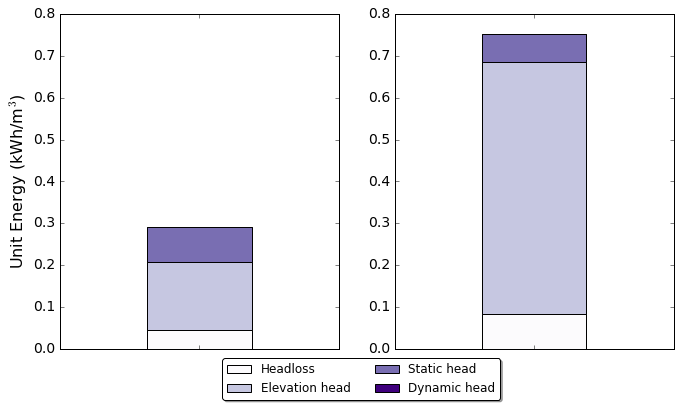

In [50]:
pump_plot_low=pump_plot_l[7:8]
pump_plot_high=pump_plot_h[7:8]
#pump_plot_high=pump_plot[(-1-1):-1]
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(121) # Create matplotlib axes
ax2 = fig.add_subplot(122)
pump_plot_low.index=[" "]
pump_plot_high.index=[" "]
a=pump_plot_low.plot(kind='bar', stacked=True,ax=ax,legend=False,colormap='Purples',fontsize=14, width=0.3)
a.set_ylim(0,0.8)
b=pump_plot_high.plot(kind='bar', stacked=True,ax=ax2,legend=False,colormap='Purples',fontsize=14, width=0.3)
#pump_plot_high.plot(kind='bar', stacked=True,figsize=(6,6),legend=True,colormap='summer',fontsize=14)
a.set_ylabel('Unit Energy (kWh/m$^3$)',fontsize=16)
plt.legend(bbox_to_anchor=(0.4, -0.01),ncol=2, fancybox=True, shadow=True)


In [51]:
total_energy_decentralized = pd.read_csv('total_energy_decentralized_m3_npr_SF.csv')
total_GHG_decentralized = pd.read_csv('total_GHG_decentralized_m3_npr_SF.csv')

In [52]:
#total_cost_decentralized_conveyance['Index']=total_cost_decentralized_conveyance.grid_ID.map(str)+" "+total_cost_decentralized_conveyance.People.map(str)
#total_cost['Index']=total_cost.grid_ID.map(str)+" "+total_cost.People.map(str)
#merged_cost = pd.merge(left=total_cost_decentralized_conveyance,right=total_cost, left_on='Index', right_on='Index')

total_energy_decentralized['Index']=total_energy_decentralized.grid_ID.map(str)+" "+total_energy_decentralized.People.map(str)
total_energy['Index']=total_energy.grid_ID.map(str)+" "+total_energy.People.map(str)
merged_energy = pd.merge(left=total_energy_decentralized,right=total_energy, left_on='Index', right_on='Index')

total_GHG_decentralized['Index']=total_GHG_decentralized.grid_ID.map(str)+" "+total_GHG_decentralized.People.map(str)
total_GHG['Index']=total_GHG.grid_ID.map(str)+" "+total_GHG.People.map(str)
merged_GHG = pd.merge(left=total_GHG_decentralized,right=total_GHG, left_on='Index', right_on='Index')

In [53]:
results2=merged_energy[(merged_energy['Total_Energy_final_y_m3'] < merged_energy['Total_Energy_m3'])][['grid_ID_x','People_x','Total_Energy_final_y_m3','Total_Energy_m3']]

In [54]:
results_GHG=merged_GHG[(merged_GHG['Total_GHG_final_y_m3'] < merged_GHG['Total_GHG_m3'])][['grid_ID_x','People_x','Total_GHG_final_y_m3','Total_GHG_m3']]

In [55]:
#results2.to_csv('results_decentral_best_npr_unbranched.csv')

In [56]:
#results_GHG.to_csv('results_decentral_best_ghg_npr_unbranched.csv')

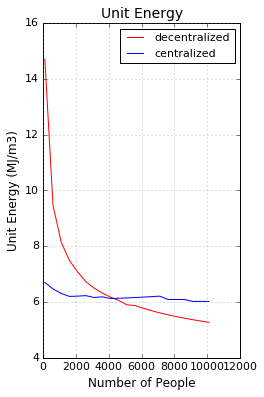

In [65]:
total_energy_decentralized_1=total_energy_decentralized[(total_energy_decentralized['grid_ID']==149)]
total_energy_1=total_energy[(total_energy['grid_ID']==149)]
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,3,1)
plt.title('Unit Energy',fontsize=14)
a=plt.plot(total_energy_decentralized_1['People'],total_energy_decentralized_1['Total_Energy_final_y_m3'],'-r',label = 'decentralized')
b=plt.plot(total_energy_1['People'],total_energy_1['Total_Energy_m3'],'-b',label = 'centralized')
legend = plt.legend(frameon = 1, fontsize=11,loc='best')
plt.ylabel('Unit Energy (MJ/m3)',fontsize=12)
plt.xlabel('Number of People',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.yaxis.grid(color='gray', linestyle=':')
ax.xaxis.grid(color='gray', linestyle=':')

In [58]:
grouped_decentral_energy=total_energy_decentralized.groupby(total_energy_decentralized['grid_ID'])
grouped_central_energy=total_energy.groupby(total_energy['grid_ID'])
grouped_decentral_GHG=total_GHG_decentralized.groupby(total_GHG_decentralized['grid_ID'])
grouped_central_GHG=total_GHG.groupby(total_GHG['grid_ID'])

In [59]:
def group_in_cluster(dtframe1,field):
    grouped_decentral_energy=dtframe1.groupby(dtframe1[field])
    grid_ID_decentral=[[] for i in range(len(dtframe1))]
    for gr, item in grouped_decentral_energy:
        dt=item
        grid_ID_decentral[gr].append(dt)
    return grid_ID_decentral

In [60]:
grid_ID_decentral=group_in_cluster(total_energy_decentralized,'grid_ID')
grid_ID_central=group_in_cluster(total_energy,'grid_ID')
unique_grid_ID=total_energy_decentralized['grid_ID'].unique()
grid_ID_decentral_GHG=group_in_cluster(total_GHG_decentralized,'grid_ID')
grid_ID_central_GHG=group_in_cluster(total_GHG,'grid_ID')


In [61]:
#min_people.to_csv('min_people_energy_unbranch_npr.csv')
#min_people_GHG.to_csv('min_people_GHG_unbranch_npr.csv')

In [62]:
process_energy_m3=process_energy[['grid_ID','People', 'Pipe_capital_energy_final_y','Pump_capital_energy_final_y','Tank_capital_energy_final_y', 'Pipe_operat_energy_final_y', 'Pump_operat_energy_final_y','Pipe_construction_energy_final_y','Pipe_excavation_energy_final_y','Pipe_transport_energy_final_y','tank_const_energy_final_y','tank_transport_energy_final_y','pump_construction_energy_final_y','pump_transport_energy_final_y','Treatment_operational_energy_y','Treatment_capital_energy_y','Tertiary_Treatment_operational_energy_y','RO_Capital_energy_y','UV_capital_energy_y','UV_operational_energy_y','Chlorine_operational_energy_y','Sludge_transport_energy_final_y','Total_conveyance_operational_energy_collection_y']]
#process_energy_m3=process_energy[['grid_ID','People', 'Pipe_capital_energy_final_y_m3','Pump_capital_energy_final_y_m3','Tank_capital_energy_final_y_m3', 'Pipe_operat_energy_final_y_m3', 'Pump_operat_energy_final_y_m3','Pipe_construction_energy_final_y_m3','Pipe_excavation_energy_final_y_m3','Pipe_transport_energy_final_y_m3','tank_const_energy_final_y_m3','tank_transport_energy_final_y_m3','pump_construction_energy_final_y_m3','pump_transport_energy_final_y_m3','Treatment_operational_energy_y_m3','Treatment_capital_energy_y_m3','RSF_capital_energy_y_m3','RSF_operational_energy_y_m3','CoagFlocc_Capital_energy_y_m3','CoagFlocc_Operational_energy_y_m3','Chlorine_operational_energy_y_m3','Sludge_transport_energy_final_y_m3','Total_conveyance_operational_energy_collection_y_m3']]
process_GHG_m3=process_GHG[['grid_ID','People', 'Pipe_capital_GHG_final_y','Pump_capital_GHG_final_y','Tank_capital_GHG_final_y', 'Pipe_operat_GHG_final_y', 'Pump_operat_GHG_final_y','Pipe_construction_GHG_final_y','Pipe_excavation_GHG_final_y','Pipe_transport_GHG_final_y','tank_const_GHG_final_y','tank_transport_GHG_final_y','pump_construction_GHG_final_y','pump_transport_GHG_final_y','Treatment_operational_GHG_y','Treatment_capital_GHG_y','Tertiary_Treatment_operational_GHG_y','RO_Capital_GHG_y','UV_capital_GHG_y','UV_operational_GHG_y','Chlorine_operational_GHG_y','Sludge_transport_GHG_y','Sludge_disposal_GHG_y','Treatment_operational_direct_GHG_y','Total_conveyance_operational_GHG_collection_y']]

In [63]:
total_energy_m3=total_energy[['grid_ID','People', 'Total_conveyance_capital_energy_central_y','Total_conveyance_operational_energy_central_y', 'Total_Treatment_capital_energy_y','Total_Treatment_operational_energy_y','Total_Energy_m3','Total_conveyance_operational_energy_collection_y']]
#total_energy_m3=total_energy[['grid_ID','People', 'Total_conveyance_capital_energy_central_y_m3','Total_conveyance_operational_energy_central_y_m3', 'Total_Treatment_operational_energy_y_m3','Total_Treatment_operational_energy_y_m3','Total_Energy_final_central_y_m3','Total_conveyance_operational_energy_collection_y_m3']]
total_GHG_m3=total_GHG[['grid_ID','People', 'Total_conveyance_capital_GHG_central_y','Total_conveyance_operational_GHG_central_y', 'Total_Treatment_capital_GHG_y','Total_Treatment_operational_GHG_y','Total_GHG_m3','Treatment_operational_direct_GHG_y','Total_conveyance_operational_GHG_collection_y']]
#total_GHG_m3=total_GHG[['grid_ID','People', 'Total_conveyance_capital_GHG_central_y_m3','Total_conveyance_operational_GHG_central_y_m3', 'Total_Treatment_capital_GHG_y_m3','Total_Treatment_operational_GHG_y_m3','Total_GHG_final_central_y_m3','Total_conveyance_operational_GHG_collection_y_m3']]

In [64]:
#total_energy_y.to_csv('C:\Users\Olga\Documents\RENUWIT\Decentralization_SF\Decentralization_model\\total_energy_centralized_y.csv')
total_energy_m3.to_csv('total_energy_centralized_m3_unbranch_npr_SF.csv')
#total_GHG_y.to_csv('C:\Users\Olga\Documents\RENUWIT\Decentralization_SF\Decentralization_model\\total_GHG_centralized_y.csv')
total_GHG_m3.to_csv('total_GHG_centralized_m3_unbranch_npr_SF.csv')
#process_energy_y.to_csv('C:\Users\Olga\Documents\RENUWIT\Decentralization_SF\Decentralization_model\\process_energy_centralized_y.csv')
process_energy_m3.to_csv('process_energy_centralized_m3_unbranch_npr_SF.csv')
#process_GHG_y.to_csv('C:\Users\Olga\Documents\RENUWIT\Decentralization_SF\Decentralization_model\\process_GHG_centralized_y.csv')
process_GHG_m3.to_csv('process_GHG_centralized_m3_unbranch_npr_SF.csv')